参考 [pyg文档](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html)

# 定义基本结构

In [1]:
import torch
from torch_geometric.data import Data

edge_index 表明哪些节点朝哪些方向连接, 两个节点单向连接只需要写一组, 双向连接需要写两组，需要注意的是，无向图实际上是指节点都通过双向边连接，而不是只连接而没有方向。

![](https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg)

In [74]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

# 节点特征矩阵, 特征可以是任意维度张量, 但是 shape 要统一, 节点特征数可以多于节点数
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

edge_index 在定义时 shape 是 [2, \*], 如果定义为 [\*, 2] 则需要转置输入Data, 转置后还需深拷贝 `contiguous()`

```python
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
```

`edge_index()` 验证 data 是否有问题, 比如 edge_index 中连接了 4 个节点,  x 中就应该依次包括大于等于 4 个节点的特征.

In [75]:
data.validate(raise_on_error=True)  # 验证数据是否有问题

True

# data 属性

In [59]:
data.num_nodes  # 节点数, 如果存在孤立节点, 结果不一定正确, 可以手动指定

4

In [60]:
data.num_edges  # 边数

4

In [61]:
data.num_node_features  # 节点特征数, 但是对高维特征识别似乎不正确

1

In [62]:
data.has_isolated_nodes()  # 是否有孤立节点

True

In [63]:
data.has_self_loops()  # 是否有自环边

False

In [64]:
data.is_directed()  # 是否有向图

False

# 标准数据集

ENZYMES 蛋白酶数据

In [25]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset("", name='ENZYMES')

In [26]:
len(dataset)  # 一共有600个图，每个图中包含若干节点

600

In [27]:
dataset.num_classes  # 一共有6个酶类别

6

In [28]:
dataset.num_node_labels

3

In [29]:
dataset.num_node_features

3

In [10]:
data = dataset[0]

In [11]:
data.is_undirected()

True

## 划分数据集

这里就手动划分为9:1了，600*0.9=540

In [13]:
dataset = dataset.shuffle()  # 打乱数据集

In [14]:
train_dataset = dataset[:540]
test_dataset = dataset[540:]

# 图卷积神经网络

Cora 是引文数据集

In [30]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid("", name='Cora')

In [31]:
dataset.num_node_features

1433

In [32]:
dataset.num_classes

7

In [33]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [35]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8070


可视化图，用networkx包

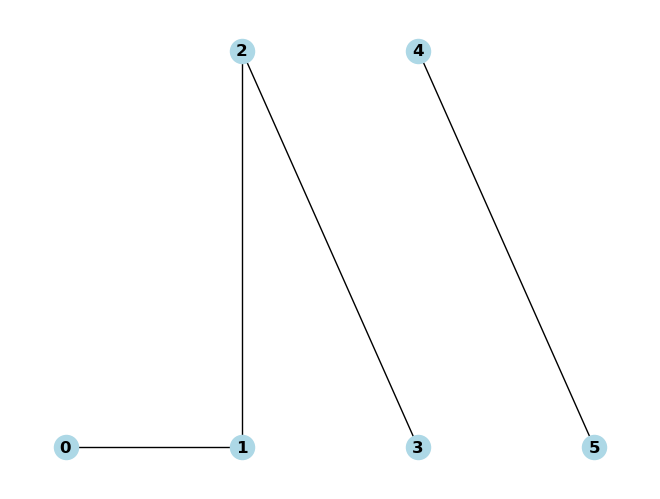

In [1]:
import torch
from torch_geometric.data import Data

# 生成一个简单的图数据，包括节点特征和位置信息
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 4, 5],
                           [1, 0, 2, 1, 3, 2, 5, 4]], dtype=torch.long)
x = torch.tensor([[1.0], [2.0], [3.0], [4.0], [5.0], [6.0]], dtype=torch.float)
pos = torch.tensor([[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [2.0, 0.0], [2.0, 1.0], [3.0, 0.0]])

data = Data(x=x, edge_index=edge_index, pos=pos)

# 这时可以使用节点位置信息来可视化图
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(range(len(x)))
G.add_edges_from(edge_index.t().tolist())

pos_dict = {i: pos[i].numpy() for i in range(len(pos))}
nx.draw(G, pos_dict, with_labels=True, font_weight='bold', node_color='lightblue')
plt.show()

# 异构图